<a href="https://colab.research.google.com/github/mrmahiislam/CVPR/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
DATASET_DIR = "/content/drive/My Drive/Colab Notebooks/Assignment-1/animal_dataset"
TRAIN_DIR = DATASET_DIR
IMG_SIZE = 32

In [89]:
!pip install opencv-python scikit-learn matplotlib

In [90]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier

def load_images_from_folder(base_folder):
    X = []
    y = []
    classes = sorted(os.listdir(base_folder))
    print("Found classes:", classes)

    for class_name in classes:
        class_folder = os.path.join(base_folder, class_name)
        if not os.path.isdir(class_folder):
            continue
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img_resized.flatten())
            y.append(class_name)
    X = np.array(X, dtype=np.float32)
    y = np.array(y)
    print(f"Loaded {X.shape[0]} images. Feature shape: {X.shape}")
    return X, y

In [91]:
X, y_str = load_images_from_folder(TRAIN_DIR)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_str)

print("Label mapping:")
for cls, enc in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{cls} -> {enc}")

Found classes: ['cat', 'dog', 'panda']
Loaded 300 images. Feature shape: (300, 1024)
Label mapping:
cat -> 0
dog -> 1
panda -> 2


In [92]:
X = X / 255.0

In [93]:
k_values = [1, 3, 5, 7, 9, 11]
metrics = ["euclidean", "manhattan"]
results = {metric: [] for metric in metrics}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for metric in metrics:
    print(f"\nDistance Metric: {metric}")
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, X, y, cv=skf, scoring='accuracy')
        avg_acc = np.mean(scores)
        results[metric].append(avg_acc)
        print(f"K={k}: fold accuracies={scores}, avg={avg_acc:.4f}")


Distance Metric: euclidean
K=1: fold accuracies=[0.38333333 0.41666667 0.3        0.36666667 0.33333333], avg=0.3600
K=3: fold accuracies=[0.36666667 0.28333333 0.41666667 0.31666667 0.4       ], avg=0.3567
K=5: fold accuracies=[0.45       0.3        0.43333333 0.33333333 0.38333333], avg=0.3800
K=7: fold accuracies=[0.38333333 0.31666667 0.4        0.38333333 0.36666667], avg=0.3700
K=9: fold accuracies=[0.4        0.36666667 0.38333333 0.38333333 0.35      ], avg=0.3767
K=11: fold accuracies=[0.33333333 0.36666667 0.38333333 0.41666667 0.38333333], avg=0.3767

Distance Metric: manhattan
K=1: fold accuracies=[0.41666667 0.36666667 0.28333333 0.41666667 0.33333333], avg=0.3633
K=3: fold accuracies=[0.43333333 0.36666667 0.41666667 0.38333333 0.3       ], avg=0.3800
K=5: fold accuracies=[0.38333333 0.31666667 0.38333333 0.33333333 0.36666667], avg=0.3567
K=7: fold accuracies=[0.45       0.33333333 0.41666667 0.43333333 0.35      ], avg=0.3967
K=9: fold accuracies=[0.4        0.41666667

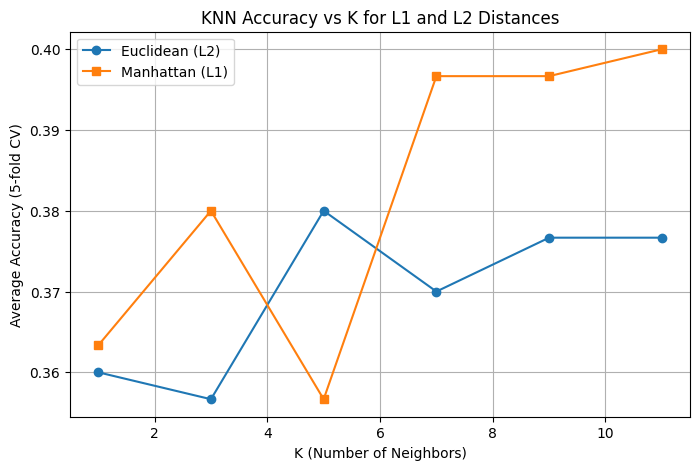

In [94]:
plt.figure(figsize=(8,5))
plt.plot(k_values, results["euclidean"], marker='o', label='Euclidean (L2)')
plt.plot(k_values, results["manhattan"], marker='s', label='Manhattan (L1)')
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Average Accuracy (5-fold CV)")
plt.title("KNN Accuracy vs K for L1 and L2 Distances")
plt.grid(True)
plt.legend()
plt.show()

In [95]:
best_k, best_metric, best_acc = None, None, -1
for metric in metrics:
    for k, acc in zip(k_values, results[metric]):
        if acc > best_acc:
            best_acc = acc
            best_k = k
            best_metric = metric

print(f"\nBest configuration:")
print(f"Distance Metric: {best_metric}")
print(f"K: {best_k}")
print(f"Average CV Accuracy: {best_acc:.4f}")


Best configuration:
Distance Metric: manhattan
K: 11
Average CV Accuracy: 0.4000


In [96]:
best_knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
best_knn.fit(X, y)
print("Final k-NN model trained on all training data.")

Final k-NN model trained on all training data.



Top 5 Predictions:
True: dog, Predicted: dog
True: dog, Predicted: dog
True: cat, Predicted: dog
True: cat, Predicted: dog
True: cat, Predicted: cat


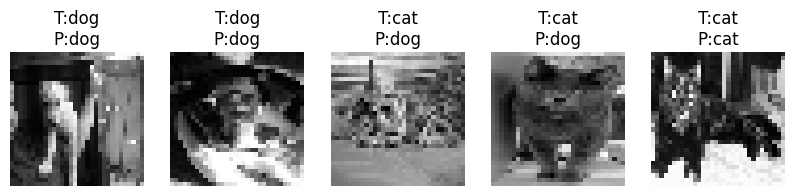

In [97]:
import random

sample_indices = random.sample(range(X.shape[0]), 5)
X_sample = X[sample_indices]
y_sample_true = y[sample_indices]

y_pred_sample = best_knn.predict(X_sample)
y_pred_labels = label_encoder.inverse_transform(y_pred_sample)
y_true_labels = label_encoder.inverse_transform(y_sample_true)

print("\nTop 5 Predictions:")
for i, idx in enumerate(sample_indices):
    print(f"True: {y_true_labels[i]}, Predicted: {y_pred_labels[i]}")

plt.figure(figsize=(10,2))
for i, idx in enumerate(sample_indices):
    plt.subplot(1,5,i+1)
    plt.imshow(X[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"T:{y_true_labels[i]}\nP:{y_pred_labels[i]}")
    plt.axis('off')
plt.show()